# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [2]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

The following function computes the intercept and slope of the least squares fit.

In [3]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [4]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.017453851471802756)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [5]:
inter + slope * 25

7.2667432601061215

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [6]:
slope * 10

0.17453851471802756

The following function evaluates the fitted line at the given `xs`.

In [7]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [8]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

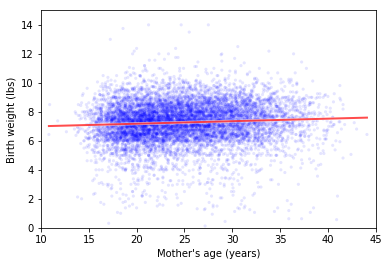

In [9]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following function computes the residuals.

In [10]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [11]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

--> I'm a bit confused by why there are 12 (and eventually 10) groups, but just three percentiles. His description of the plot (specifically "percentile of the residuals") vs. average age in each group doesn't seem entirely precise. 

I think I see it now. groups are what create the distinctions between the line breaks/angles. The first group is (average) ages 10-13 and the last is 43-46 based on my inspection of the `bins` variable. For each of the ten displayed bins we're seeing the 25, 50th, and 75th percentiles of the *residuals*. For instance, 75% of residuals for ages 16-19 are ~0.75 lbs or lbs or lower. 

Recall:
**percentile rank**: The percentage of values in a distribution that are less than or ewqual to a given value.

**percentile**: The value associated with a given percentile rank.

In this case **percentile rank** is 75 (%) and the percentile is +0.75 lbs (for the residuals of the linear least squares model.)

In [12]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]

Next I'll compute the CDF of the residuals in each group.

Looks like it's taking the second through the second of last group (ten total).

In [13]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [14]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

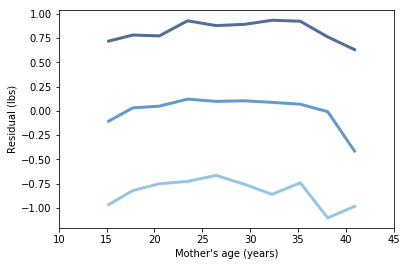

In [15]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling distribution - Estimation

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

Recall:

In statistics, a **sample distribution** or finite-sample distribution is the probability distribution of a given random-sample-based statistic.

In [85]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True) #This takes the whole length of the original df but resample with replacement

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [17]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [18]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [19]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [20]:
Summarize(inters)

mean, SE, CI 6.827880009181971 0.07075818805238833 (6.714926373977412, 6.945590456470338)


And for `slope`.

In [21]:
Summarize(slopes)

mean, SE, CI 0.017558102533328665 0.002773294151537828 (0.01297818948218666, 0.021955508704530283)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

How is mean birth weight different than .totalwgt_lb?

In [22]:
iters = 1001

#Create a list of estimate based on 1000 iterations
estimates = []
for _ in range(iters):
    estimate = ResampleRows(live).totalwgt_lb.mean()
    estimates.append(estimate)
    
Summarize(estimates)



mean, SE, CI 7.265933426221929 0.014713527189001346 (7.241127738437707, 7.289043483071476)


## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

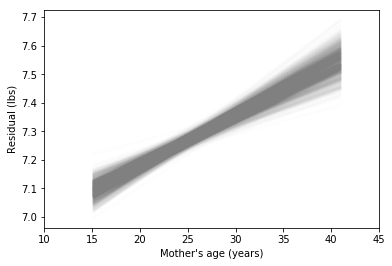

In [23]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

->Each point on the x axis represents its own series and thus can be treated as population itself. Within that population of values, there are percentiles.

In [24]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options): 
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p #Becauyse a range is shown
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

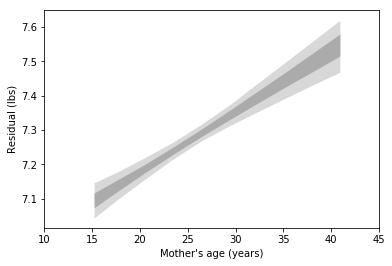

In [25]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [26]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [27]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710369

We can confirm that $R^2 = \rho^2$:

In [28]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410907
R 0.0688339703541091


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [29]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857834


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [30]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes - Testing a Linear Model

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [100]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [32]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [33]:
ht.actual, ht.MaxTestStat()

(0.017453851471802756, 0.008883395352456127)

We can also use resampling to estimate the sampling distribution of the slope.

In [34]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one (the null hypothesis, [by one definition](https://stattrek.com/regression/slope-test.aspx)!) has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

-> It's not clear to me at what point the cdf of the null hypothesis is calculated. Perhaps somewhere buried in the inherited `HypothesisTest` class of `ht = SlopeTest((ages, weights))`.

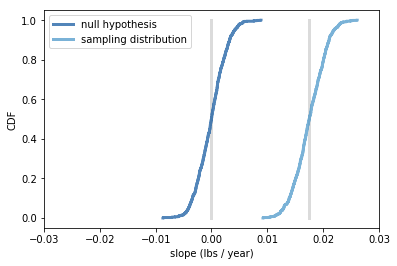

In [35]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [36]:
pvalue = sampling_cdf[0]
pvalue

0.0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [37]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [38]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.345299775946005 0.015413005112571758 (7.318979586191635, 7.368236888692189)


And here's what the same calculation looks like if we ignore the weights.

In [39]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.26731819816331 0.014405243621826285 (7.24482739544147, 7.2895690418234125)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [40]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [70]:
inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918145, 0.0052814541694177946)

Make a scatter plot of the data and show the fitted line.

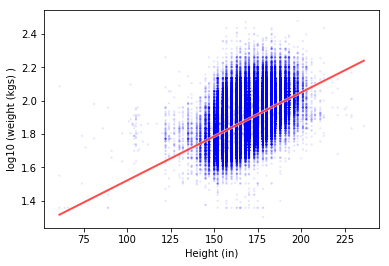

In [71]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=5)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (in)",
                 ylabel='log10 (weight (kgs) )',)
                 #axis=[50, 250, 1, 2.5],
                 #legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

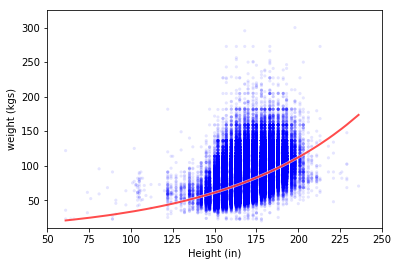

In [72]:
#fit_xs, fit_ys = FitLine(heights, inter, slope)
thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)

thinkplot.Plot(fit_xs, 10**fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (in)",
                 ylabel='weight (kgs)',
                 axis=[50, 250, 10, 325],
                 legend=False)

#thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
#fxs, fys = thinkstats2.FitLine(heights, inter, slope)
#thinkplot.Plot(fxs, 10**fys, color='red') #Inverse transform of log - take power to the base, in this case 10
#thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plot percentiles of the residuals.

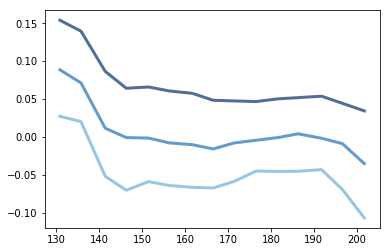

In [74]:
#Reset to log transformed data

inter, slope = LeastSquares(heights, log_weights)
fit_xs, fit_ys = FitLine(heights, inter, slope)

df['residual'] = thinkstats2.Residuals(heights, log_weights, inter, slope)

bins = np.arange(50, 250, 3) #Basically creating three groups across x-axis range

#Downy's solution
bins = np.arange(130, 210, 5) #Why'd he choose this range? Omits a lot of the nastiness on either side

indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

height_means = [group.htm3.mean() for _, group in groups][1:-1]

#Create cdfs for 
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(height_means, weights, label=label)

# Solution goes here

#Reset weights variable - 'weights' used above in for loop
weights = df.wtkg2

Hm, well if I've done this correctly the residuals don't appear to be flat -- particularly with the lower weights), so perhaps they are not random? Book suggests that flatness is related to random (error?).

Residuals are higher towards the tails of the distributions of x values, which makes sense if you looks at the scatter plot. There are fewer points (as with all normal distributions) and there are some that noticably deviate from the trend line (suprisingly high weight for very low height #fatties).

[This post](https://math.stackexchange.com/questions/834681/when-residual-standard-error-is-equal-to-standard-deviation-of-dependent-variabl) is helpful in understanding how to compare the two.

Compute correlation.

In [75]:
P = thinkstats2.Corr(heights, log_weights)
P

0.5317282605983439

Compute coefficient of determination.

In [46]:
res = Residuals(heights, log_weights, inter, slope)
r2 = CoefDetermination(log_weights, res)
r2

print(r2,P**2)

0.282734943118939 0.2827349431189403


Confirm that $R^2 = \rho^2$.

In [47]:
# Solution goes here

Compute Std(ys), which is the RMSE of predictions that don't use height.

I'm still not entirely clear on how these predictions would be made? Randomly? always +- 1 stdev?

-> The formulas for RMSE and StdDev are quite similar (at least in their structure), the underlying variables are a bit different. (?)

In [48]:
np.std(log_weights)

0.10320725029999761

Compute Std(res), the RMSE of predictions that do use height.

In [49]:
np.std(res)

0.08740777080416087

How much does height information reduce RMSE?

In [50]:
(np.std(log_weights) - np.std(res)) / np.std(res)

0.18075600544985682

Use resampling to compute sampling distributions for inter and slope.

In [86]:
def SamplingDistributions(df, iters=101):
    t = []
    for _ in range(iters):
        #sample = ResampleRows(df)
        #heights = sample.htm3
        #log_weights = np.log10(sample.wtkg2)
        #estimates = LeastSquares(heights, log_weights)
        #t.append(estimates)
        
        #Downey's soln - it looks the same
        sample = thinkstats2.ResampleRows(df)
        estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

inters, slopes = SamplingDistributions(df, iters=101) #Downey used 101

#inters[:50]

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

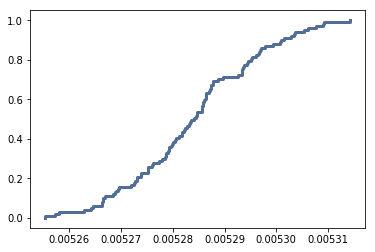

In [104]:
ht = SlopeTest((heights, log_weights))
sampling_cdf = thinkstats2.Cdf(slopes)

#I had this below code plotting the null hypothesis as well, but I'm not sure if that was entirely correct
"""thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
#ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / in)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')
"""
#This was Downey's soln
thinkplot.Cdf(sampling_cdf)

Compute the p-value of the slope.

In [105]:
pvalue = sampling_cdf[0]
pvalue

0.0

Compute the 90% confidence interval of slope.

In [106]:
sampling_cdf.ConfidenceInterval(90)

(0.005264631503301613, 0.005305472216477141)

Compute the mean of the sampling distribution.

In [107]:
sampling_cdf.Mean()

0.005284008849306251

Compute the standard deviation of the sampling distribution, which is the standard error.

In [108]:
stderr = thinkstats2.Std(slopes)
stderr

1.2480217382527913e-05

Resample rows without weights, compute mean height, and summarize results.

In [109]:
iters = 100
estimates = [ResampleRows(df).htm3.mean() for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 168.95683378301908 0.01680744716088129 (168.92901028719254, 168.98384415610664)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [111]:
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

iters = 100
estimates = [ResampleRowsWeighted(df).htm3.mean() for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 170.49858376786113 0.018204234397919537 (170.46237039956344, 170.53031841791466)
